# Tracked Thermal Properties in a trained TNN
To Showcase in dissertation for the TNN

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys 
from pathlib import Path
from tqdm import tqdm
import torch
from mawkutils.render import prettify
from mawkutils.data import KaggleDataSet, ChunkedKaggleDataSet, SmoothKaggleDataSet, DBManager as DBM
from mawkutils.topology import TNNCell, DifferenceEqLayer
from mawkutils.validation import generate_tensor

IMG_PATH = Path().cwd().parent / 'notebooks' / 'img'
device = torch.device('cpu')

In [2]:
var_name2sym = {'pm': 'PM', 'ambient': 'A', 'coolant': 'C', 'stator_yoke': 'SY', 'stator_tooth': 'ST', 'stator_winding': 'SW'}
STATEDICT_PATH = Path().cwd().parent / 'data' / 'output' / 'torch_state_dicts'
ds = KaggleDataSet()
ds.featurize(scheme='basic')
ds.normalize()


conds_correspondence = []
temp_cols = ds.target_cols + [i for i in ds.input_cols if i in ds.temperature_cols]  # according to TNN forward()
for i, t in enumerate(temp_cols):
    for tt in temp_cols[i+1:]:
        conds_correspondence.append(f'{var_name2sym[t]}-{var_name2sym[tt]}')
conds_correspondence = conds_correspondence[:-1]  # drop ambient-coolant conductance
conds_correspondence

['PM-SY',
 'PM-ST',
 'PM-SW',
 'PM-A',
 'PM-C',
 'SY-ST',
 'SY-SW',
 'SY-A',
 'SY-C',
 'ST-SW',
 'ST-A',
 'ST-C',
 'SW-A',
 'SW-C']

In [3]:
# load up meta and data
best_expid = 85223  # smallest tnn with best worst-case error

# generate tensors
train_l, val_l, test_l = ds.get_profiles_for_cv(cv_lbl='1fold_no_val_static_diss')
train_l, test_l = train_l[0], test_l[0]
train_tensor, train_sample_weights = generate_tensor(train_l, ds, device)
#val_tensor, val_sample_weights = generate_tensor(val_l or [], ds, device)
test_tensor, test_sample_weights = generate_tensor(test_l, ds, device)

# read out layer_cfg from DB
meta_info_tnn = DBM.query(f"SELECT experiment_id, seed, mse, l_infty_under, l_infty_over, model_size, model_tag, comment, started_at, finished_at, hostname, layer_cfg FROM trials as t "
                            f"LEFT JOIN experiments as e ON t.experiment_id = e.id "
                            f"where experiment_id = {best_expid} "
                            f"ORDER BY t.mse ASC;")
meta_info_tnn['WorstCase'] = meta_info_tnn.loc[:, ["l_infty_over", "l_infty_under"]].abs().max(axis=1)
meta_info_tnn['train_time'] = meta_info_tnn.finished_at - meta_info_tnn.started_at
meta_info_tnn = meta_info_tnn.sort_values(['model_size', 'WorstCase'])

Fold 0 test size: 133584 samples (10.0% of total)
Test ssh tunnel..ok


In [4]:
meta_info_tnn

,experiment_id,seed,mse,l_infty_under,l_infty_over,model_size,model_tag,comment,started_at,finished_at,hostname,layer_cfg,WorstCase,train_time
0,85223,7,2.597593,-4.607194,5.608192,113,tnn,HPO study_4_diss_reduce_lr trial-nr 34385,2023-03-01 10:40:02,2023-03-01 11:15:52,n2cn0512,"{""p"": [{""units"": 2, ""activation"": ""tanh"", ""nam...",5.608192,0 days 00:35:50
1,85223,6,3.143933,-6.397753,6.039819,113,tnn,HPO study_4_diss_reduce_lr trial-nr 34385,2023-03-01 10:40:02,2023-03-01 11:15:22,n2cn0512,"{""p"": [{""units"": 2, ""activation"": ""tanh"", ""nam...",6.397753,0 days 00:35:20
4,85223,3,3.765874,-5.818227,6.525061,113,tnn,HPO study_4_diss_reduce_lr trial-nr 34385,2023-03-01 10:40:02,2023-03-01 11:15:56,n2cn0512,"{""p"": [{""units"": 2, ""activation"": ""tanh"", ""nam...",6.525061,0 days 00:35:54
2,85223,9,3.635751,-4.691557,6.705030,113,tnn,HPO study_4_diss_reduce_lr trial-nr 34385,2023-03-01 10:40:02,2023-03-01 11:16:06,n2cn0512,"{""p"": [{""units"": 2, ""activation"": ""tanh"", ""nam...",6.705030,0 days 00:36:04
9,85223,2,4.641000,-6.723171,7.182362,113,tnn,HPO study_4_diss_reduce_lr trial-nr 34385,2023-03-01 10:40:02,2023-03-01 11:15:36,n2cn0512,"{""p"": [{""units"": 2, ""activation"": ""tanh"", ""nam...",7.182362,0 days 00:35:34
5,85223,8,4.078759,-7.201683,6.030049,113,tnn,HPO study_4_diss_reduce_lr trial-nr 34385,2023-03-01 10:40:02,2023-03-01 11:15:27,n2cn0512,"{""p"": [{""units"": 2, ""activation"": ""tanh"", ""nam...",7.201683,0 days 00:35:25
3,85223,1,3.640159,-7.283755,5.729249,113,tnn,HPO study_4_diss_reduce_lr trial-nr 34385,2023-03-01 10:40:02,2023-03-01 11:16:11,n2cn0512,"{""p"": [{""units"": 2, ""activation"": ""tanh"", ""nam...",7.283755,0 days 00:36:09
7,85223,5,4.398691,-4.340112,7.513120,113,tnn,HPO study_4_diss_reduce_lr trial-nr 34385,2023-03-01 10:40:02,2023-03-01 11:15:52,n2cn0512,"{""p"": [{""units"": 2, ""activation"": ""tanh"", ""nam...",7.513120,0 days 00:35:50
6,85223,10,4.153971,-5.211019,8.460895,113,tnn,HPO study_4_diss_reduce_lr trial-nr 34385,2023-03-01 10:40:02,2023-03-01 11:15:56,n2cn0512,"{""p"": [{""units"": 2, ""activation"": ""tanh"", ""nam...",8.460895,0 days 00:35:54
10,85223,0,7.632420,-6.330080,8.653769,113,tnn,HPO study_4_diss_reduce_lr trial-nr 34385,2023-03-01 10:32:18,2023-03-01 11:10:26,n2cn0512,"{""p"": [{""units"": 2, ""activation"": ""tanh"", ""nam...",8.653769,0 days 00:38:08


In [5]:
json.loads(meta_info_tnn.iloc[0, :].layer_cfg)

{'p': [{'units': 2, 'activation': 'tanh', 'name': 'p_0'},
  {'units': 4, 'activation': 'sigmoid', 'name': 'p_output'}],
 'g': [{'units': 2, 'activation': 'relu', 'name': 'g_0'},
  {'units': 15, 'activation': 'biased_elu', 'name': 'g_output'}],
 'cap': [-2.6957365529917117,
  -16.697095809512952,
  -8.75059038609224,
  -9.674541583334552]}

In [6]:
# load models of best experiment
models = []
for seed in range(11):
    mdl = DifferenceEqLayer(TNNCell, n_targets=len(ds.target_cols), input_feats=ds.input_cols, 
                            temperature_cols=ds.temperature_cols,
                            sample_time=ds.sample_time, non_temperature_cols=ds.non_temperature_cols,
                            layer_cfg=json.loads(meta_info_tnn.iloc[0, :].layer_cfg)).to(device)
    #mdl = torch.jit.script(mdl)  # new syntax as of pytorch 1.2
    mdl.load_state_dict(torch.load(
        STATEDICT_PATH / f"exp_{best_expid}_seed_{seed}_fold_0.pt"))
    models.append(mdl)

In [7]:
# track thermal parameters
therm_props_per_model_l = []
with torch.inference_mode():
    for mdl in models:
        therm_props_d = {}
        #hidden = norm_data.loc[norm_data.p_id == pui, target_cols].iloc[0, :].to_numpy().astype(np.float32)
        mat = ds.data.loc[:, ds.input_cols + ds.target_cols].to_numpy()
        #inph = torch.from_numpy(np.hstack([inp.astype(np.float32), hidden])).to(device)
        inph = torch.from_numpy(mat.astype(np.float32)).to(device)
        therm_props_d['cond'] = mdl.cell.conductance_net(inph).numpy()  # biased_elu
        therm_props_d['ploss'] = np.abs(mdl.cell.ploss(inph).numpy())
        therm_props_d['inv_caps'] = mdl.cell.caps.numpy()
        therm_props_per_model_l.append(therm_props_d)

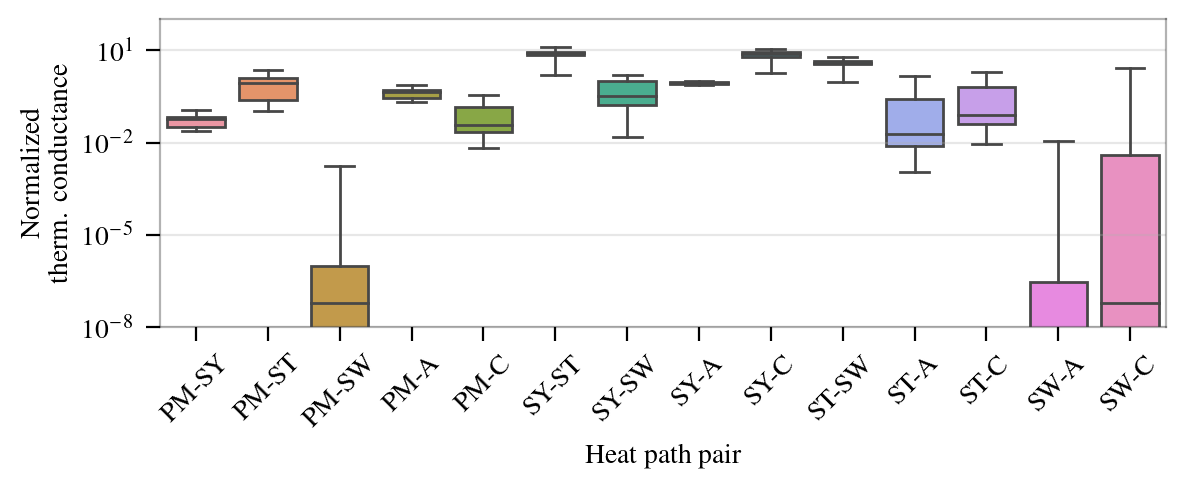

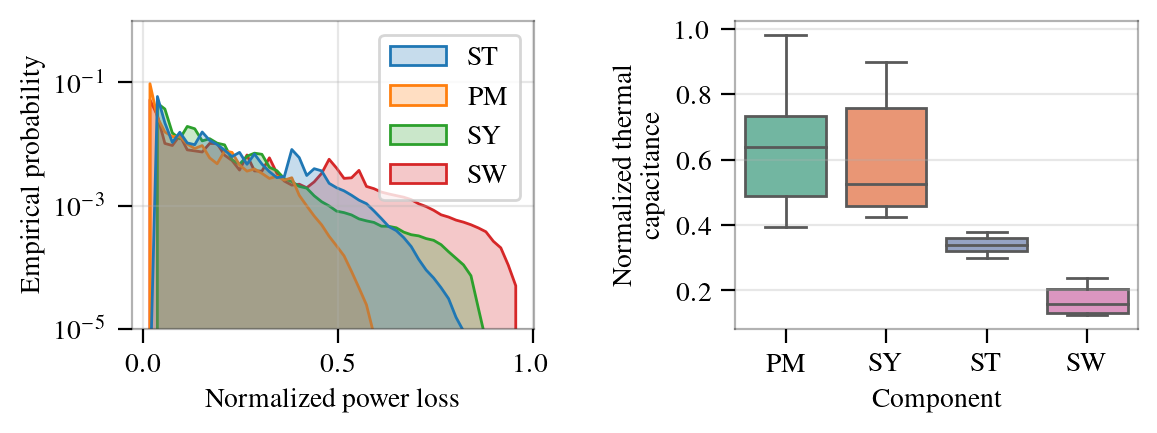

In [10]:
# mix: conductances as boxplot, ploss as hist plot

#fig, axes = plt.subplots(nrows=1, #len(models),
#                         ncols=2, sharex=False, sharey=False, figsize=(17, 5))
# for i, therm_props in tqdm(enumerate(therm_props_per_model_l)):
# conductances
fig_size = (6.49, 2)
therm_props = therm_props_per_model_l[7]

# Thermal Conductances
fig = plt.figure(figsize=fig_size, dpi=200)
ax = fig.add_subplot(111)

conductances_df = pd.DataFrame(
    therm_props['cond'][:, :-1], columns=conds_correspondence)
conductances_df = pd.concat([conductances_df[[c]].rename(
    columns={c: 'cond'}).assign(pair=c) for c in conductances_df], ignore_index=True)
g = sns.boxplot(data=conductances_df, x='pair', y='cond', ax=ax , whis=(0, 100), linewidth=1)
g.set_xticklabels(g.get_xticklabels(), rotation=45,)
 
ax.set_ylim([1e-8, 1e2])
ax.set_yscale('log')
g.set_ylabel('Normalized\n therm. conductance')
g.set_xlabel('Heat path pair')
#ax.set_xscale('log')
prettify(ax)
fig.savefig(IMG_PATH / "diss_therm_props_g.pdf", dpi = 300, bbox_inches = "tight")

# Power Losses and caps
fig, axes = plt.subplots(1, 2, figsize=fig_size, dpi=200, sharex=False, sharey=False)
ax = axes[0] #fig.add_subplot(121)

ploss_df = pd.DataFrame(therm_props['ploss'], columns=ds.target_cols)
ploss_df = pd.concat([ploss_df[[c]].rename(columns={c: 'ploss'}).assign(
    component=var_name2sym[c]) for c in ploss_df], ignore_index=True)
g = sns.histplot(data=ploss_df, x='ploss',stat='probability', element='poly', bins=50, legend=True,
                 hue='component', ax=ax, kde=False, hue_order=['ST', 'PM', 'SY', 'SW'], 
                 )
ax.set_yscale('log')
ax.set_ylim(1e-5, 1e-0)
#g.set_xticklabels(np.array(g.get_xticks()*100).astype(int))
g.set_xlabel('Normalized power loss')
g.set_ylabel("Empirical probability")
l = g.get_legend()
#l.remove()
l.set_title('')
l.set_ncols(2)

# Thermal Capacitances

ax = axes[1] #fig.add_subplot(122)

inv_caps_df = 1/np.exp(pd.DataFrame([therm_props['inv_caps']
                       for therm_props in therm_props_per_model_l], columns=ds.target_cols)) / 1600
inv_caps_df = pd.concat([inv_caps_df[[c]].rename(columns={c: 'invcaps'}).assign(
    component=var_name2sym[c]) for c in inv_caps_df], ignore_index=True)

# g = seaborn.histplot(data=inv_caps_df, x='inv_caps',stat='probability', bins=100, legend=True,
#                 hue='component', ax=ax, kde=False, hue_order=['ST', 'PM', 'SY', 'SW'])
g = sns.boxplot(data=inv_caps_df, x='component', y='invcaps', ax=ax, whis=(0, 100), palette="Set2", linewidth=1
                    #hue_order=['ST', 'PM', 'SY', 'SW']
                    )
# ax.set_yscale('log')
#ax.set_ylim(1e-3, 2e-2)
g.set_ylabel('Normalized thermal\n capacitance')
g.set_xlabel("Component")
# g.legend(ncol=2)
fig.subplots_adjust(wspace=0.5)
prettify(axes[0])
prettify(axes[1])

fig.savefig(IMG_PATH / "diss_therm_props_pc.pdf", dpi=300, bbox_inches="tight")

## Start chart median therm. conductances

In [19]:
conductances_df.groupby('pair').median().to_dict()

{'cond': {'PM-A': 0.4454260468482971,
  'PM-C': 0.03713080286979675,
  'PM-ST': 0.8308894634246826,
  'PM-SW': 5.960464477539063e-08,
  'PM-SY': 0.056393206119537354,
  'ST-A': 0.01903197169303894,
  'ST-C': 0.07986554503440857,
  'ST-SW': 3.863351821899414,
  'SW-A': 0.0,
  'SW-C': 5.960464477539063e-08,
  'SY-A': 0.8394796848297119,
  'SY-C': 7.616391658782959,
  'SY-ST': 8.044950485229492,
  'SY-SW': 0.32093140482902527}}

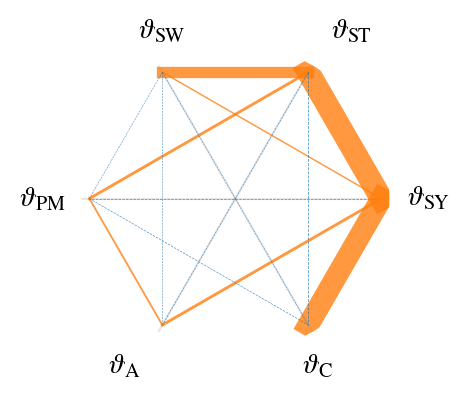

In [37]:
tmp2sym = {'PM': r'$\vartheta_\mathrm{PM}$',
          'SY': r'$\vartheta_\mathrm{SY}$',
          'ST': r'$\vartheta_\mathrm{ST}$',
          'SW': r'$\vartheta_\mathrm{SW}$',
          'A': r'$\vartheta_\mathrm{A}$',
          'C': r'$\vartheta_\mathrm{C}$'}

drop_g = ["PM-SW", "SW-A", "SW-C", "PM-SY", "PM-C", "ST-A", "ST-C"]
median_medians = conductances_df.groupby('pair').median().to_dict()['cond']

temps_ordered = ['SY', 'ST', 'SW', 'PM', 'A', 'C']
angles = np.linspace(0, 2*np.pi, len(temps_ordered), endpoint=False).tolist()
#angles += [angles[0]]
temp_coords = []
for i, t in enumerate(temps_ordered):
    for j, tt in enumerate(temps_ordered[i+1:], start=i+1):
        temp_coords.append((i, j))
fig, ax = plt.subplots(figsize=(2, 2), subplot_kw=dict(polar=True))

for i, j in temp_coords:
    
    lbl = [l for l in median_medians if f'{temps_ordered[i]}' in l and f'{temps_ordered[j]}' in l]

    if len(lbl) == 0:
        continue
    lbl = lbl[0]
    if lbl in drop_g:
        clr = 'tab:blue'
        ls = 'dashed'
    else:
        clr = 'tab:orange'
        ls = '-'
    ax.plot([angles[i], angles[j]], [1,1], color=clr, lw=0.2+1*median_medians[lbl], alpha=0.8, ls=ls)
# prettify
for label, angle in zip(ax.get_xticklabels(), angles):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')
ax.set_thetagrids(np.degrees(angles), [tmp2sym[t] for t in temps_ordered])
ax.set_rgrids([])
ax.spines['polar'].set_color('none')

fig.savefig(IMG_PATH / "diss_cond_starchart.pdf", dpi=300, bbox_inches="tight")

# Smallest models performance

In [11]:
import seaborn as sns
meta_df = DBM.query("SELECT * FROM trials as t "
                    "LEFT JOIN experiments as e ON t.experiment_id = e.id "
                    "WHERE e.debug = false and e.scriptname = 'run_custom_dyn_experiment_4_diss.py' "
                    "and e.comment ilike 'sparse %' "
                    "ORDER BY t.mse ASC;")


Test ssh tunnel..ok


In [12]:
top_descr ={85244: "2 NNs, 2 neurons", 85245: "1 NN, 2 neurons", 
     85246: "1 NN, 1 neuron", 85247: "2 NNs, 1 neuron"}
for k, v in top_descr.items():
    msize = meta_df.query("experiment_id == @k").model_size.iloc[0]
    top_descr[k] += f', {msize} params'
meta_df.loc[:, "Arch"] = meta_df.experiment_id.map(top_descr)
meta_df.loc[:, 'WorstCase'] = meta_df.loc[:, ["l_infty_over", "l_infty_under"]].abs().max(axis=1)
meta_df.sort_values("WorstCase")

,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,...,debug,dataset,n_folds,input_cols,target_cols,model_size,comment,layer_cfg,Arch,WorstCase
1,85245,2023-04-03 10:21:00,2023-04-03 11:17:53,23,2.050615,5.638130,-5.993497,85245,single_sub_tnn,mse,...,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",68,"sparse single_sub tnn, 7 less conductances fe_...","{""p"": [{""units"": 2, ""activation"": ""tanh""}, {""u...","1 NN, 2 neurons, 68 params",5.993497
11,85245,2023-04-03 09:21:09,2023-04-03 10:21:50,3,2.356129,5.400508,-6.311574,85245,single_sub_tnn,mse,...,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",68,"sparse single_sub tnn, 7 less conductances fe_...","{""p"": [{""units"": 2, ""activation"": ""tanh""}, {""u...","1 NN, 2 neurons, 68 params",6.311574
17,85245,2023-04-03 10:21:11,2023-04-03 11:17:00,26,2.464467,6.403441,-5.340546,85245,single_sub_tnn,mse,...,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",68,"sparse single_sub tnn, 7 less conductances fe_...","{""p"": [{""units"": 2, ""activation"": ""tanh""}, {""u...","1 NN, 2 neurons, 68 params",6.403441
2,85245,2023-04-03 10:20:53,2023-04-03 11:13:31,22,2.061245,6.427152,-5.729908,85245,single_sub_tnn,mse,...,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",68,"sparse single_sub tnn, 7 less conductances fe_...","{""p"": [{""units"": 2, ""activation"": ""tanh""}, {""u...","1 NN, 2 neurons, 68 params",6.427152
5,85245,2023-04-03 09:21:09,2023-04-03 10:17:08,1,2.165903,6.512731,-6.422344,85245,single_sub_tnn,mse,...,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",68,"sparse single_sub tnn, 7 less conductances fe_...","{""p"": [{""units"": 2, ""activation"": ""tanh""}, {""u...","1 NN, 2 neurons, 68 params",6.512731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,85246,2023-04-03 08:42:47,2023-04-03 09:35:33,5,203.951550,34.264960,-68.638565,85246,single_sub_tnn,mse,...,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",42,"sparse single-sub tnn, 1 neuron, 7 less conduc...","{""p"": [{""units"": 1, ""activation"": ""tanh""}, {""u...","1 NN, 1 neuron, 42 params",68.638565
117,85246,2023-04-03 10:27:26,2023-04-03 11:19:40,18,204.684330,34.235394,-68.657326,85246,single_sub_tnn,mse,...,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",42,"sparse single-sub tnn, 1 neuron, 7 less conduc...","{""p"": [{""units"": 1, ""activation"": ""tanh""}, {""u...","1 NN, 1 neuron, 42 params",68.657326
116,85245,2023-04-03 10:17:08,2023-04-03 11:15:25,18,204.636100,34.218296,-68.723840,85245,single_sub_tnn,mse,...,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",68,"sparse single_sub tnn, 7 less conductances fe_...","{""p"": [{""units"": 2, ""activation"": ""tanh""}, {""u...","1 NN, 2 neurons, 68 params",68.723840
118,85246,2023-04-03 10:27:03,2023-04-03 11:18:53,17,205.417940,34.055298,-68.805390,85246,single_sub_tnn,mse,...,False,chunked_kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",42,"sparse single-sub tnn, 1 neuron, 7 less conduc...","{""p"": [{""units"": 1, ""activation"": ""tanh""}, {""u...","1 NN, 1 neuron, 42 params",68.805390


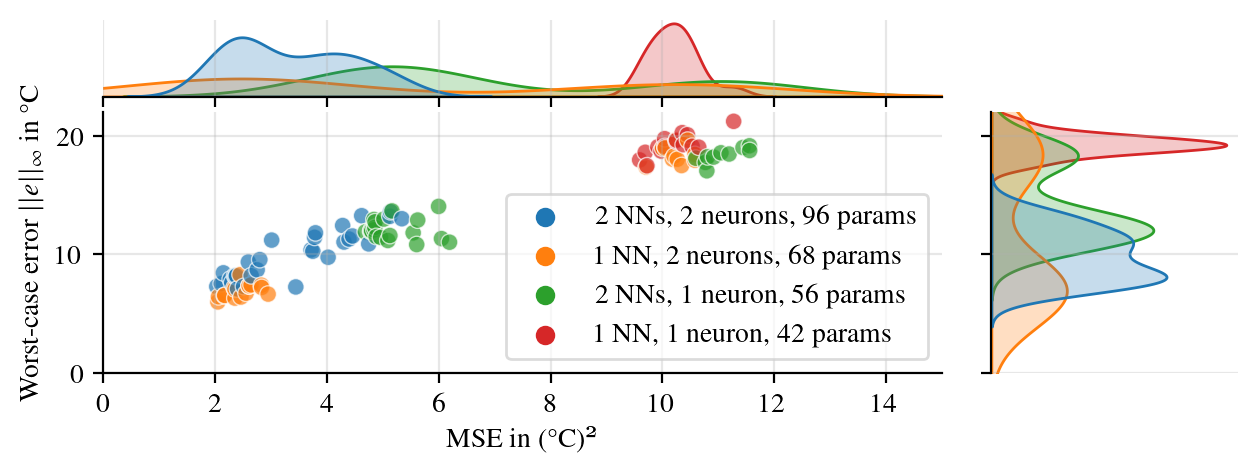

In [13]:
# seaborn jointplot

fig_size = (6.49, 2.0)   # fit into diss format

g = sns.jointplot(data=meta_df.query("WorstCase <= 25 and mse < 15"), x='mse', y='WorstCase', hue='Arch', ratio=3, alpha=0.7)
ax = g.fig.get_axes()[0]
ax.legend(loc='lower right', #bbox_to_anchor=(.1, 0.9),
          #bbox_transform=fig.transFigure, 
          frameon=True, framealpha=0.7)
ax.set_ylim([0, 22])
ax.set_xlim([0.0, 15])
ax.set_ylabel("Worst-case error $||e||_\infty$ in °C")
ax.set_xlabel("MSE in (°C)²")
ax.set_alpha(0.5)
g.fig.set_size_inches(*fig_size)
g.fig.set_dpi(200)
g.savefig(IMG_PATH / "diss_smallest_tnns_jointplot.pdf", dpi=300, bbox_inches='tight')


# Detuned Init / ISS

In [14]:
from mawkutils.validation import generate_tensor
from mawkutils.topology import SingleSubNNTNNCell

ds = SmoothKaggleDataSet()
ds.featurize()
ds.normalize()

MODEL_DUMP_PATH = Path.cwd().parent / 'data' / 'output' / 'torch_state_dicts'
best_exp_id, best_seed = 85245, 23

device = torch.device('cpu')
# generate tensors
cv_method = "1fold_static_diss"
train_l, val_l, test_l = ds.get_profiles_for_cv(cv_method)
test_tensor, test_sample_weights = generate_tensor(test_l[0], ds, device)

layer_cfg_d = json.loads(meta_df.query(f"experiment_id == {best_exp_id} and seed == {best_seed}").layer_cfg.iloc[0])
# g output neurons is overstated due to inner workings of singlesubNNTNNcell
layer_cfg_d['g'][-1]['units'] -= len(ds.target_cols)
tnn = DifferenceEqLayer(SingleSubNNTNNCell, n_targets=len(ds.target_cols),
                        input_feats=ds.input_cols, temperature_cols=ds.temperature_cols,
                        sample_time=ds.sample_time, non_temperature_cols=ds.non_temperature_cols,
                        layer_cfg=layer_cfg_d).to(device)
tnn.load_state_dict(torch.load(
    MODEL_DUMP_PATH / f'exp_{best_exp_id}_seed_{best_seed}_fold_0.pt'))
detuned_trajectories = []
with torch.inference_mode():

    for i in range(30):
        hidden = torch.from_numpy(
            np.random.uniform(low=test_tensor[0, :, -len(ds.target_cols):]-0.5,
                              high=test_tensor[0, :, -len(ds.target_cols):]+0.5,
                              size=(test_tensor.shape[1], len(ds.target_cols))).astype(np.float32))
        fold_pred, hidden = tnn(test_tensor[:, :, :len(ds.input_cols)], hidden)
        detuned_trajectories.append(fold_pred)


Fold 0 test size: 133584 samples (10.0% of total)


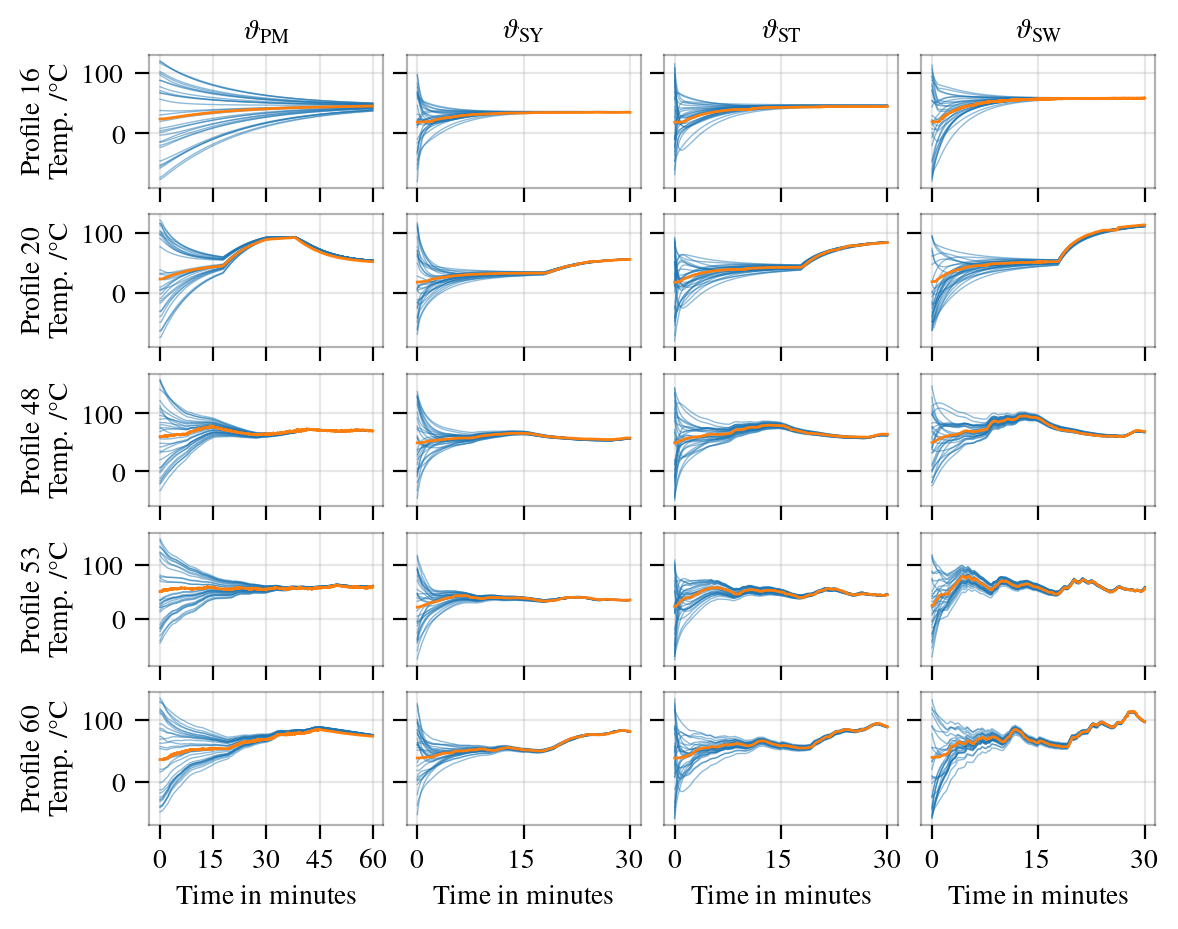

In [15]:
# plot detuned init
fig_size = (6.49, 5.0)   # fit into diss format
target_labels = [r'$\vartheta_\mathrm{PM}$', r'$\vartheta_\mathrm{SY}$',
                 r'$\vartheta_\mathrm{ST}$', r'$\vartheta_\mathrm{SW}$', ]
fig, axes = plt.subplots(test_tensor.shape[1], len(ds.target_cols), figsize=fig_size, sharey='row', sharex="col")


for profile_i in range(test_tensor.shape[1]):
    for target_i, target_col in enumerate(ds.target_cols):
        cropped_t_axis = np.arange(7200) if target_i == 0 else np.arange(3600)
        gtruth = ds.temperature_scale* test_tensor[:len(cropped_t_axis), profile_i, target_i-len(ds.target_cols)]

        ax = axes[profile_i, target_i]
        
        for pred in detuned_trajectories:
            ax.plot(cropped_t_axis, ds.temperature_scale*pred[:len(cropped_t_axis), profile_i, target_i-len(ds.target_cols)], "-",
                    alpha=.5, color='tab:blue', label="Estimate", lw=0.5)
        ax.plot(cropped_t_axis, gtruth, '-', alpha=1,
                color='tab:orange', label="Ground truth", lw=1)
        # ax.text(0.1, 0.85, s = f"MSE: {((pred-gtruth)**2).mean():.2f} (°C)²",
        #        bbox = dict(facecolor='green', alpha=0.3), transform = ax.transAxes)
        if target_i == 0:
            ax.set_ylabel(f'Profile {test_l[0][profile_i]}\nTemp. /°C')
        if profile_i+1 == test_tensor.shape[1]:
            ax.set_xlabel('Time in minutes')
        elif profile_i == 0:
            ax.set_title(target_labels[target_i])
        #ax.legend(loc = "upper right")

        tcks = np.arange(0, len(cropped_t_axis) + 2*60*15, 2*60*15 )
        tcks_lbls = tcks //  60 // 2
        ax.set_xticks(tcks)
        ax.set_xticklabels(tcks_lbls)
        """ax.text(0.7, 0.2,
                s=target_labels[target_i], #fontsize='large',
                #bbox={'facecolor': 'white', 'edgecolor': 'grey', 'alpha': 1.0, 'pad': 1.0},
                transform=ax.transAxes,
                verticalalignment='bottom', horizontalalignment='center')"""
        prettify(ax)
        #ax.set_ylim(None, 100)
fig.subplots_adjust(wspace=0.1)
fig.savefig(IMG_PATH / "diss_detuned_init.pdf", dpi = 300, bbox_inches = "tight")